In [1]:
import numpy as np
import wave
import os
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import random
import math

In [2]:
labels = ['Time:256Hz','Epoch','F3','FC5','AF3','F7','T7','P7','O1','O2','P8','T8','F8','AF4','FC6','F4','Label','Stage','Flag']
print(labels)
channels = ['F3','FC5','AF3','F7','T7','P7','O1','O2','P8','T8','F8','AF4','FC6','F4']
nchan = len(channels)
print(channels)

['Time:256Hz', 'Epoch', 'F3', 'FC5', 'AF3', 'F7', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'F8', 'AF4', 'FC6', 'F4', 'Label', 'Stage', 'Flag']
['F3', 'FC5', 'AF3', 'F7', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'F8', 'AF4', 'FC6', 'F4']


Load FEIS Dataset
---

In [26]:
from numpy import genfromtxt
data = genfromtxt("s1_full_eeg.csv", delimiter=',', skip_header = 1,dtype=str)
data = np.delete(data,np.s_[-1:],axis=1)
data_original = np.copy(data)
print(data)
data.size

[['5.0' '0' '4372.0512695313' ... '4315.6411132813' 'goose' 'stimuli']
 ['5.00390625' '0' '4366.5385742188' ... '4308.4614257813' 'goose'
  'stimuli']
 ['5.0078125' '0' '4361.9228515625' ... '4302.9487304688' 'goose'
  'stimuli']
 ...
 ['3523.98828125' '159' '4264.7436523438' ... '4218.3334960938' 's'
  'resting']
 ['3523.9921875' '159' '4261.41015625' ... '4217.3076171875' 's'
  'resting']
 ['3523.99609375' '159' '4259.615234375' ... '4215.0' 's' 'resting']]


15482880

Normalize data
---

In [58]:
#Normalize each channel separately

data_norm = np.copy(data)
data_norm = np.delete(data_norm,[0,1,-1,-2],1)
data_norm = data_norm.astype(float)

normed_rows = np.copy(data_norm)

for chan in range(len(data_norm.T)):
    mean = np.mean(data_norm.T[chan])
    stdev = np.std(data_norm.T[chan])
    for samp in range(len(data_norm.T[chan])):
        normed_rows.T[chan][samp] = (data_norm.T[chan][samp] - mean) / stdev

data_norm = normed_rows.astype(str)

for chan in range(nchan):
    data[:,chan+2] = data_norm[:,chan]

In [6]:
procedures = ['resting','stimuli','thinking','speaking']
phonemes = ['goose','thought','zh','p','sh','n','k','fleece','trap','s','ng','t','f','z','m']

Structure data nested by task, phoneme, epoch, & sample
---

In [69]:
#Initialize struct for each phone/procedure combo
struct = [[],[],[],[]] #struct[procedure][phone][epoch][channel]
for task in range(len(procedures)):
    for phone in phonemes:
        struct[task].append([])

#Load EEG matrices into struct
for task in range(len(procedures)):
    for phone in range(len(phonemes)):
        
        epoch_ct = 0
        epoch_index = 0
        struct[task][phone].append([])
        for i in range(len(data)):
            if data[i][-2] == phonemes[phone] and data[i][-1] == procedures[task]:
                if float(data[i][1]) > epoch_ct:
                    struct[task][phone].append([data[i][0:16]])
                    epoch_ct = float(data[i][1])
                    epoch_index += 1
                else:
                    struct[task][phone][epoch_index].append(data[i][0:16])
    print("task:",task)
    
for task in range(len(procedures)):
    for phone in range(len(phonemes)):
        if struct[task][phone][0] == []:
            del struct[task][phone][0]

task: 0
task: 1
task: 2
task: 3


In [70]:
print(len(struct),'Tasks')
print(len(struct[0]),'Phonemes')
print(len(struct[0][0]),'Epochs')
print(len(struct[0][0][0][0]),'Time,nEpoch,channels')

4 Tasks
15 Phonemes
10 Epochs
16 Time,nEpoch,channels


Isolate Sound in Audio Files
---

In [71]:
def extract_audio(fname):
    input_data = read(fname)
    audio = input_data[1]
    plt.plot(audio[0:len(audio)])
    #print(len(audio),"Samples")
    #print(len(audio)/1000,"Frames/ms")
    
    if False:
        plt.ylabel("Amplitude")
        plt.xlabel("Time")
        plt.title(fname)
        plt.show()
        
    return audio

In [72]:
def isolate_sound(audio):
    start = 0
    end = 0
    start_found = False
    for frame in range(len(audio)):
        if audio[frame] > 100:
            end = frame
            if not start_found:
                start = frame
                start_found = True
    
    start_time = start/len(audio)
    end_time = end/len(audio)
    #print("Start Time:",start_time,"s")
    #print("End Time:",end_time,"s")
    return start_time, end_time

thought.wav
k.wav
zh.wav
n.wav
fleece.wav
trap.wav
m.wav
z.wav
v.wav
t.wav
f.wav
p.wav
ng.wav
s.wav
goose.wav
sh.wav


{'thought.wav': (0.1692063492063492, 0.6371428571428571),
 'k.wav': (0.18217687074829933, 0.3958503401360544),
 'zh.wav': (0.3193877551020408, 0.77859410430839),
 'n.wav': (0.21634920634920635, 0.7289795918367347),
 'fleece.wav': (0.27494331065759636, 0.6484580498866214),
 'trap.wav': (0.1773922902494331, 0.5819501133786849),
 'm.wav': (0.4148299319727891, 0.8319047619047619),
 'z.wav': (0.16850340136054423, 0.6305895691609977),
 'v.wav': (0.1045124716553288, 0.46408163265306124),
 't.wav': (0.08229024943310657, 0.2808843537414966),
 'f.wav': (0.13494331065759638, 0.5904761904761905),
 'p.wav': (0.23839002267573697, 0.446530612244898),
 'ng.wav': (0.1418140589569161, 0.844671201814059),
 's.wav': (0.22732426303854875, 0.6972108843537415),
 'goose.wav': (0.20997732426303856, 0.6384353741496599),
 'sh.wav': (0.19673469387755102, 0.6691836734693878)}

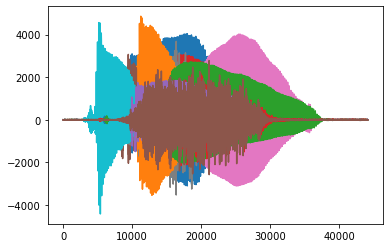

In [73]:
#Determine windows within audio files when subject was sounding phoneme
wav_time_dict = {} #Tuples to start and end times indexed by wav audio file name
file_names = os.listdir('s1_wavs')
for fname in file_names:
    print(fname)
    audio = extract_audio('s1_wavs/'+fname)
    wav_time_dict[fname] = (isolate_sound(audio))

wav_time_dict

Map phoneme occurence from Audio to EEG
---

In [74]:
#Separates all EEG samples from within the audio time window (not taking into account perception delay)
def isolate_eeg_sounds(task, phonemes,wav_time_dict):
    
    n100 = 0.07 #N100 occurs 80ms after stim onset, as first indication of stimuli presentation
    long_feats_all_phonemes = []
    for phone in range(len(phonemes)):
    
        wav_start,wav_end = wav_time_dict[phonemes[phone]+'.wav'] #Start/End of phoneme in wav audio clip

        long_features = [] #Contains groups of all continous sounds
        for epoch in struct[task][phone]:
            sound_packet = [] #1 continous sound (not whole 5 seconds of repetition)
            init_repetition = int(float(epoch[0][0]))
            repetition = init_repetition
            for sample in epoch:

                #Determines if EEG sample is in the audio window
                sample_formatted = float('0.' + sample[0].split('.')[1])
                if sample_formatted > (wav_start + n100) and sample_formatted < wav_end:
                    if int(float(sample[0])) == repetition:
                        sound_packet.append(sample)
                    else:
                        repetition = int(float(sample[0]))
                        long_features.append(sound_packet.copy())
                        sound_packet = []
                        
            long_features.append(sound_packet.copy()) #Each appended packet is a single sound
                
        long_feats_all_phonemes.append(long_features)
        
    return long_feats_all_phonemes

In [75]:
long_feats_listen = isolate_eeg_sounds(1, phonemes) #stimuli/listening
long_feats_think = isolate_eeg_sounds(2, phonemes) #stimuli/listening

In [216]:
print(float(long_feats_listen[0][0][13][0]) - float(long_feats_listen[0][0][0][0])) #Window size = 13 samples
print(float(long_feats_think[0][0][13][0]) - float(long_feats_think[0][0][0][0])) #Window size = 13 samples

print(float(long_feats_listen[0][0][1][0]) - float(long_feats_listen[0][0][0][0])) #Difference over 1 time point

0.05078125
0.05078125
0.00390625


Produce sequential windows representing phoneme time series samples
---

In [173]:
def construct_dataset(long_feats, phonemes, window_size=13, offset=13):
    
    #window_size = 13 => 0.0507 second samples = 51ms < L_phoneme
    
    #Construct dataset with samples of sliding window for each phoneme
    phoneme_datasets = []

    for phone in range(len(phonemes)):
        ds = []
        for sound_packet in long_feats[phone]:
            ind_max = len(sound_packet)
            start = 0
            end = window_size
            while ind_max > end:
                ds.append(sound_packet[start:end])
                start += offset
                end += offset
        phoneme_datasets.append(ds)
        
    structured_dataset = []
    for phone_ds in phoneme_datasets:
        temp_phone = []
        for sound_packet in phone_ds:
            temp_packet = []
            for timepoint in sound_packet:
                temp_packet.append(timepoint[2:])
            temp_phone.append(temp_packet)
        structured_dataset.append(np.asarray(temp_phone).astype(float))
    
    return structured_dataset

In [174]:
structured_dataset_listen = construct_dataset(long_feats_listen, phonemes)
structured_dataset_think = construct_dataset(long_feats_think, phonemes)

print(len(structured_dataset_listen)) #Number of phonemes
print(len(structured_dataset_listen[0])) #Number of sound packets
print(len(structured_dataset_listen[0][0])) #Number of timepoints/sound packet
print(len(structured_dataset_listen[0][0][0])) #Number of channels
print()
print(len(structured_dataset_think)) #Number of phonemes
print(len(structured_dataset_think[0])) #Number of sound packets
print(len(structured_dataset_think[0][0])) #Number of timepoints/sound packet
print(len(structured_dataset_think[0][0][0])) #Number of channels

15
310
13
14

15
310
13
14


Split training/validation datasets
---

In [203]:
def split_data(x,t,training_size=0.8): #x=phoneme[i], t=target phoneme label

    #Identifies indices to split data by
    data_index = np.arange(len(t))
    random.shuffle(data_index)
    training_index = data_index[:int(training_size*len(t))]
    testing_index = data_index[int(training_size*len(t)):]

    training_x = []
    training_t = []
    for index in training_index:
        training_x.append(x[index])
        training_t.append(t[index])

    testing_x = []
    testing_t = []
    for index in testing_index:
        testing_x.append(x[index])
        testing_t.append(t[index])
        
    training_x = np.asarray(training_x)
    training_t = np.asarray(training_t)
    testing_x = np.asarray(testing_x)
    testing_t = np.asarray(testing_t)
    
    return training_x,training_t,testing_x,testing_t

In [204]:
#Stack all samples into single matrix
x = [] #datapoints
t = [] #labels
for phone in range(len(structured_dataset_listen)):
    for sound_packet in structured_dataset_listen[phone]:
        x.append(sound_packet)
        t.append(phone)

print(len(x))
print(len(t))

training_x,training_t,testing_x,testing_t = split_data(x,t)

print("training_x:",len(training_x))
print("testing_x:",len(testing_x))
print("training_t:",len(training_t))
print("testing_t:",len(testing_t))

4560
4560
training_x: 3648
testing_x: 912
training_t: 3648
testing_t: 912


MLP Model - Train&Test on stim/audio EEG
---

In [177]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_hub as hub

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [178]:
input_shape = (training_x.shape[1:])
print(input_shape)
print(training_x.shape)

(13, 14)
(3648, 13, 14)


In [214]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_shape)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(15, activation=tf.keras.activations.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

tf.keras.backend.set_value(model.optimizer.learning_rate, 0.000005)

model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 182)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 1000)              183000    
_________________________________________________________________
dense_117 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_118 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_119 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_120 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_121 (Dense)            (None, 1000)            

In [211]:
history = model.fit(training_x, training_t, epochs=100)

Epoch 1/100
114/114 [==============================] - 5s 36ms/step - loss: 2.7060 - accuracy: 0.0778
Epoch 2/100
114/114 [==============================] - 4s 34ms/step - loss: 2.6569 - accuracy: 0.1333
Epoch 3/100
114/114 [==============================] - 4s 38ms/step - loss: 2.5955 - accuracy: 0.1410
Epoch 4/100
114/114 [==============================] - 4s 37ms/step - loss: 2.5767 - accuracy: 0.1276
Epoch 5/100
114/114 [==============================] - 5s 42ms/step - loss: 2.5475 - accuracy: 0.1432
Epoch 6/100
114/114 [==============================] - 4s 36ms/step - loss: 2.5137 - accuracy: 0.1725
Epoch 7/100
114/114 [==============================] - 4s 35ms/step - loss: 2.4545 - accuracy: 0.2216
Epoch 8/100
114/114 [==============================] - 4s 33ms/step - loss: 2.4055 - accuracy: 0.2349
Epoch 9/100
114/114 [==============================] - 4s 35ms/step - loss: 2.3419 - accuracy: 0.2575
Epoch 10/100
114/114 [==============================] - 4s 33ms/step - loss: 2.265

KeyboardInterrupt: 

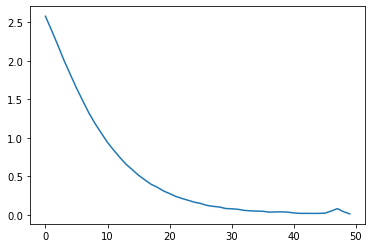

In [212]:
plt.plot(history.history['loss'])

In [215]:
def eval_model(training_x,training_t,testing_x,testing_t):

    train_loss, train_acc = model.evaluate(training_x,  training_t, verbose=2)
    print('Train accuracy:', train_acc)
    print()

    test_loss, test_acc = model.evaluate(testing_x,  testing_t, verbose=2)
    print('Test accuracy:', test_acc)

eval_model(training_x,training_t,testing_x,testing_t)

114/114 - 1s - loss: 2.7088 - accuracy: 0.0359
Train accuracy: 0.03591008856892586

29/29 [==============================] - 0s 10ms/step - loss: 2.7090 - accuracy: 0.0362
Test accuracy: 0.03618421033024788


In [86]:
chance = 1/len(phonemes)
print(chance)

0.06666666666666667


In [118]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(testing_x)

Gramian Angular Field Pre-process for CNN
---

In [87]:
#Transform dataset to Gramian Angular Field to project time series to matrix using polar coordinates
#https://pyts.readthedocs.io/en/stable/generated/pyts.image.GramianAngularField.html
#https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3
from pyts.image import GramianAngularField

def to_gaf(x_partition):
    
    x_part_gaf = []
    transformer = GramianAngularField()
    for x in x_partition:
        x_part_gaf.append(transformer.transform(x).T)
        
    x_part_gaf = np.asarray(x_part_gaf)

    return x_part_gaf

In [88]:
training_x_gaf = to_gaf(training_x)
testing_x_gaf = to_gaf(testing_x)

input_size_gaf = training_x_gaf.shape[1:]
print(input_size_gaf,'\n')
print(training_x_gaf.shape)
print(training_x.shape)

print(testing_x_gaf.shape)
print(testing_x.shape)

(14, 14, 26) 

(1680, 14, 14, 26)
(1680, 26, 14)
(420, 14, 14, 26)
(420, 26, 14)


In [93]:
model = models.Sequential()
model.add(layers.Conv2D(input_size_gaf[0], 1, padding="same", activation='relu', input_shape=input_size_gaf))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(input_size_gaf[0]*2, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(input_size_gaf[0]*2, (2, 2), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(input_size_gaf[0]*2, activation='relu'))
model.add(layers.Dense(15))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

tf.keras.backend.set_value(model.optimizer.learning_rate, 0.000025)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 14)        378       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 14)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 28)          1596      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 28)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 28)          3164      
_________________________________________________________________
flatten_2 (Flatten)          (None, 112)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 28)               

In [94]:
history = model.fit(training_x_gaf, training_t, epochs=500)

Epoch 1/500
53/53 [==============================] - 1s 4ms/step - loss: 8.4675 - accuracy: 0.0714
Epoch 2/500
53/53 [==============================] - 0s 4ms/step - loss: 8.0678 - accuracy: 0.0773
Epoch 3/500
53/53 [==============================] - 0s 4ms/step - loss: 8.1108 - accuracy: 0.0790
Epoch 4/500
53/53 [==============================] - 0s 4ms/step - loss: 7.9683 - accuracy: 0.0818
Epoch 5/500
53/53 [==============================] - 0s 4ms/step - loss: 7.8676 - accuracy: 0.0740
Epoch 6/500
53/53 [==============================] - 0s 4ms/step - loss: 7.7766 - accuracy: 0.0756
Epoch 7/500
53/53 [==============================] - 0s 4ms/step - loss: 7.5708 - accuracy: 0.0742
Epoch 8/500
53/53 [==============================] - 0s 4ms/step - loss: 7.6340 - accuracy: 0.0686
Epoch 9/500
53/53 [==============================] - 0s 4ms/step - loss: 7.3926 - accuracy: 0.0931
Epoch 10/500
53/53 [==============================] - 0s 4ms/step - loss: 7.5742 - accuracy: 0.0685
Epoch 11/

53/53 [==============================] - 0s 4ms/step - loss: 7.5640 - accuracy: 0.1085
Epoch 84/500
53/53 [==============================] - 0s 4ms/step - loss: 7.0733 - accuracy: 0.1302
Epoch 85/500
53/53 [==============================] - 0s 4ms/step - loss: 6.8842 - accuracy: 0.1160
Epoch 86/500
53/53 [==============================] - 0s 4ms/step - loss: 7.0650 - accuracy: 0.1072
Epoch 87/500
53/53 [==============================] - 0s 4ms/step - loss: 7.2596 - accuracy: 0.1152
Epoch 88/500
53/53 [==============================] - 0s 3ms/step - loss: 7.1016 - accuracy: 0.1047
Epoch 89/500
53/53 [==============================] - 0s 3ms/step - loss: 6.9466 - accuracy: 0.1152
Epoch 90/500
53/53 [==============================] - 0s 3ms/step - loss: 6.7222 - accuracy: 0.1051
Epoch 91/500
53/53 [==============================] - ETA: 0s - loss: 7.1044 - accuracy: 0.11 - 0s 3ms/step - loss: 7.1043 - accuracy: 0.1152
Epoch 92/500
53/53 [==============================] - 0s 4ms/step - los

Epoch 164/500
53/53 [==============================] - 0s 3ms/step - loss: 6.9505 - accuracy: 0.1272
Epoch 165/500
53/53 [==============================] - 0s 3ms/step - loss: 6.4647 - accuracy: 0.1424
Epoch 166/500
53/53 [==============================] - 0s 3ms/step - loss: 6.5322 - accuracy: 0.1323
Epoch 167/500
53/53 [==============================] - 0s 3ms/step - loss: 6.9030 - accuracy: 0.1238
Epoch 168/500
53/53 [==============================] - 0s 3ms/step - loss: 6.5157 - accuracy: 0.1513
Epoch 169/500
53/53 [==============================] - 0s 3ms/step - loss: 6.6234 - accuracy: 0.1360
Epoch 170/500
53/53 [==============================] - 0s 3ms/step - loss: 6.9391 - accuracy: 0.1294
Epoch 171/500
53/53 [==============================] - 0s 3ms/step - loss: 6.7938 - accuracy: 0.1310
Epoch 172/500
53/53 [==============================] - 0s 3ms/step - loss: 7.0545 - accuracy: 0.1105
Epoch 173/500
53/53 [==============================] - 0s 3ms/step - loss: 6.8476 - accurac

53/53 [==============================] - 0s 8ms/step - loss: 6.5065 - accuracy: 0.1269
Epoch 246/500
53/53 [==============================] - 0s 4ms/step - loss: 6.5819 - accuracy: 0.1410
Epoch 247/500
53/53 [==============================] - 0s 4ms/step - loss: 6.4270 - accuracy: 0.1378
Epoch 248/500
53/53 [==============================] - 0s 4ms/step - loss: 6.3758 - accuracy: 0.1595
Epoch 249/500
53/53 [==============================] - 0s 4ms/step - loss: 6.4911 - accuracy: 0.1519
Epoch 250/500
53/53 [==============================] - 0s 4ms/step - loss: 6.2781 - accuracy: 0.1411
Epoch 251/500
53/53 [==============================] - 0s 4ms/step - loss: 6.6568 - accuracy: 0.1300
Epoch 252/500
53/53 [==============================] - 0s 5ms/step - loss: 6.2759 - accuracy: 0.1370
Epoch 253/500
53/53 [==============================] - 0s 5ms/step - loss: 6.3076 - accuracy: 0.1461
Epoch 254/500
53/53 [==============================] - 0s 4ms/step - loss: 6.6254 - accuracy: 0.1292
Epoc

53/53 [==============================] - 0s 4ms/step - loss: 6.4481 - accuracy: 0.1298
Epoch 407/500
53/53 [==============================] - 0s 3ms/step - loss: 6.0856 - accuracy: 0.1449
Epoch 408/500
53/53 [==============================] - 0s 3ms/step - loss: 6.1589 - accuracy: 0.1370
Epoch 409/500
53/53 [==============================] - 0s 3ms/step - loss: 6.1779 - accuracy: 0.1385
Epoch 410/500
53/53 [==============================] - 0s 3ms/step - loss: 6.0114 - accuracy: 0.1501
Epoch 411/500
53/53 [==============================] - 0s 4ms/step - loss: 6.2214 - accuracy: 0.1441
Epoch 412/500
53/53 [==============================] - 0s 3ms/step - loss: 6.2597 - accuracy: 0.1408
Epoch 413/500
53/53 [==============================] - 0s 3ms/step - loss: 5.8957 - accuracy: 0.1358
Epoch 414/500
53/53 [==============================] - 0s 4ms/step - loss: 6.3081 - accuracy: 0.1425
Epoch 415/500
53/53 [==============================] - 0s 4ms/step - loss: 6.0353 - accuracy: 0.1461
Epoc

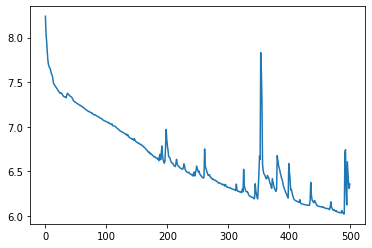

In [95]:
plt.plot(history.history['loss'])

In [96]:
eval_model(training_x_gaf,training_t,testing_x_gaf,testing_t)

53/53 - 0s - loss: 6.3160 - accuracy: 0.1500
Train accuracy: 0.15000000596046448

14/14 - 0s - loss: 7.6954 - accuracy: 0.0929
Test accuracy: 0.09285714477300644


Train on Audio Phonemes, Test on Thinking Phonemes / vice versa
---

In [183]:
#Stack all samples into single matrix
x_train = [] #listening
t_train = [] #listening
x_test = [] #think
t_test = [] #think

for phone in range(len(structured_dataset_listen)):
    for sound_packet in range(len(structured_dataset_listen[phone])):
        
        x_train.append(structured_dataset_listen[phone][sound_packet])
        t_train.append(phone)
        
        x_test.append(structured_dataset_think[phone][sound_packet])
        t_test.append(phone)

print("Train x:",len(x_train),"Train t:",len(t_train))
print("Test x:",len(x_test),"Test t:",len(t_test))
training_x,training_t,null3,null4 = split_data(x_train,t_train,training_size=1) #all listening training data
null1,null2,testing_x,testing_t = split_data(x_test,t_test,training_size=0) #all think testing data

print("training_x:",training_x.shape)
print("testing_x:",testing_x.shape)
print("training_t:",training_t.shape)
print("testing_t:",testing_t.shape)

training_x_gaf = to_gaf(training_x)
testing_x_gaf = to_gaf(testing_x)

input_size_gaf = training_x_gaf.shape[1:]
print(input_size_gaf,'\n')
print(training_x_gaf.shape)
print(training_x.shape)

print(testing_x_gaf.shape)
print(testing_x.shape)

Train x: 4560 Train t: 4560
Test x: 4560 Test t: 4560
training_x: (4560, 13, 14)
testing_x: (4560, 13, 14)
training_t: (4560,)
testing_t: (4560,)
(14, 14, 13) 

(4560, 14, 14, 13)
(4560, 13, 14)
(4560, 14, 14, 13)
(4560, 13, 14)


In [187]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_shape)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(15, activation=tf.keras.activations.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

tf.keras.backend.set_value(model.optimizer.learning_rate, 0.000025)

model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 182)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 1000)              183000    
_________________________________________________________________
dense_89 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_90 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_91 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_92 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_93 (Dense)             (None, 15)              

In [188]:
history = model.fit(training_x, training_t, epochs=50)

Epoch 1/50
143/143 [==============================] - 4s 18ms/step - loss: 2.6295 - accuracy: 0.1245
Epoch 2/50
143/143 [==============================] - 3s 18ms/step - loss: 2.4371 - accuracy: 0.2450
Epoch 3/50
143/143 [==============================] - 2s 17ms/step - loss: 2.2281 - accuracy: 0.3212
Epoch 4/50
143/143 [==============================] - 3s 19ms/step - loss: 2.0331 - accuracy: 0.3877
Epoch 5/50
143/143 [==============================] - 3s 20ms/step - loss: 1.8352 - accuracy: 0.4470
Epoch 6/50
143/143 [==============================] - 2s 16ms/step - loss: 1.6527 - accuracy: 0.5161
Epoch 7/50
143/143 [==============================] - 3s 18ms/step - loss: 1.4911 - accuracy: 0.5655
Epoch 8/50
143/143 [==============================] - 3s 18ms/step - loss: 1.3404 - accuracy: 0.6210
Epoch 9/50
143/143 [==============================] - 2s 15ms/step - loss: 1.1974 - accuracy: 0.6693
Epoch 10/50
143/143 [==============================] - 2s 16ms/step - loss: 1.0554 - accura

143/143 - 1s - loss: 0.0077 - accuracy: 1.0000
Train accuracy: 1.0

143/143 - 1s - loss: 9.3871 - accuracy: 0.0807
Test accuracy: 0.08070175349712372


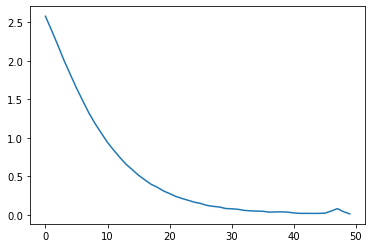

In [189]:
plt.plot(history.history['loss'])
eval_model(training_x,training_t,testing_x,testing_t)

In [395]:
model = models.Sequential()
model.add(layers.Conv2D(input_size_gaf[0], 1, padding="same", activation='relu', input_shape=input_size_gaf))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(input_size_gaf[0]*2, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(input_size_gaf[0]*2, (2, 2), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(input_size_gaf[0]*2, activation='relu'))
model.add(layers.Dense(15))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

tf.keras.backend.set_value(model.optimizer.learning_rate, 0.000025)

model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 14, 14, 14)        378       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 14)          0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 6, 6, 28)          1596      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 3, 3, 28)          0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 2, 2, 28)          3164      
_________________________________________________________________
flatten_31 (Flatten)         (None, 112)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 28)              

In [396]:
history = model.fit(testing_x_gaf, testing_t, epochs=500)

Epoch 1/500
66/66 [==============================] - 2s 13ms/step - loss: 9.2604 - accuracy: 0.0443
Epoch 2/500
66/66 [==============================] - 0s 6ms/step - loss: 8.6670 - accuracy: 0.0431
Epoch 3/500
66/66 [==============================] - 1s 8ms/step - loss: 8.4404 - accuracy: 0.0498
Epoch 4/500
66/66 [==============================] - 1s 8ms/step - loss: 8.0389 - accuracy: 0.0520
Epoch 5/500
66/66 [==============================] - 0s 7ms/step - loss: 7.9199 - accuracy: 0.0403
Epoch 6/500
66/66 [==============================] - 0s 7ms/step - loss: 8.0404 - accuracy: 0.0430
Epoch 7/500
66/66 [==============================] - 0s 7ms/step - loss: 7.6251 - accuracy: 0.0491
Epoch 8/500
66/66 [==============================] - 0s 6ms/step - loss: 7.7641 - accuracy: 0.0516
Epoch 9/500
66/66 [==============================] - 1s 8ms/step - loss: 7.6033 - accuracy: 0.0573
Epoch 10/500
66/66 [==============================] - 0s 7ms/step - loss: 7.4199 - accuracy: 0.0601: 0s - lo

66/66 [==============================] - 0s 4ms/step - loss: 5.4794 - accuracy: 0.1136
Epoch 163/500
66/66 [==============================] - 0s 4ms/step - loss: 5.4319 - accuracy: 0.1037
Epoch 164/500
66/66 [==============================] - 0s 4ms/step - loss: 5.4944 - accuracy: 0.1155
Epoch 165/500
66/66 [==============================] - 0s 4ms/step - loss: 5.4612 - accuracy: 0.1050
Epoch 166/500
66/66 [==============================] - 0s 4ms/step - loss: 5.3099 - accuracy: 0.1114
Epoch 167/500
66/66 [==============================] - 0s 5ms/step - loss: 5.2894 - accuracy: 0.1130
Epoch 168/500
66/66 [==============================] - 0s 4ms/step - loss: 5.4448 - accuracy: 0.1080
Epoch 169/500
66/66 [==============================] - 0s 5ms/step - loss: 5.5000 - accuracy: 0.1065
Epoch 170/500
66/66 [==============================] - 0s 5ms/step - loss: 5.5127 - accuracy: 0.1111
Epoch 171/500
66/66 [==============================] - 0s 5ms/step - loss: 5.3544 - accuracy: 0.1165
Epoc

66/66 [==============================] - 0s 6ms/step - loss: 4.5892 - accuracy: 0.1490
Epoch 324/500
66/66 [==============================] - 0s 7ms/step - loss: 4.6363 - accuracy: 0.1329
Epoch 325/500
66/66 [==============================] - 0s 5ms/step - loss: 4.6934 - accuracy: 0.1444
Epoch 326/500
66/66 [==============================] - 0s 8ms/step - loss: 4.6434 - accuracy: 0.1565
Epoch 327/500
66/66 [==============================] - 0s 7ms/step - loss: 4.6055 - accuracy: 0.1497
Epoch 328/500
66/66 [==============================] - 1s 9ms/step - loss: 4.7108 - accuracy: 0.1457
Epoch 329/500
66/66 [==============================] - 1s 8ms/step - loss: 4.6354 - accuracy: 0.1565
Epoch 330/500
66/66 [==============================] - 0s 6ms/step - loss: 4.4456 - accuracy: 0.1661
Epoch 331/500
66/66 [==============================] - 0s 5ms/step - loss: 4.6258 - accuracy: 0.1532
Epoch 332/500
66/66 [==============================] - 0s 6ms/step - loss: 4.5537 - accuracy: 0.1637
Epoc

66/66 [==============================] - 0s 6ms/step - loss: 4.3822 - accuracy: 0.1592
Epoch 405/500
66/66 [==============================] - 0s 7ms/step - loss: 4.2545 - accuracy: 0.1556
Epoch 406/500
66/66 [==============================] - 0s 5ms/step - loss: 4.3251 - accuracy: 0.1671
Epoch 407/500
66/66 [==============================] - 0s 6ms/step - loss: 4.2478 - accuracy: 0.1458
Epoch 408/500
66/66 [==============================] - 1s 8ms/step - loss: 4.2497 - accuracy: 0.1639
Epoch 409/500
66/66 [==============================] - 0s 6ms/step - loss: 4.3085 - accuracy: 0.1721
Epoch 410/500
66/66 [==============================] - 0s 6ms/step - loss: 4.1387 - accuracy: 0.1723
Epoch 411/500
66/66 [==============================] - 0s 6ms/step - loss: 4.3164 - accuracy: 0.1712
Epoch 412/500
66/66 [==============================] - 1s 8ms/step - loss: 4.2149 - accuracy: 0.1696
Epoch 413/500
66/66 [==============================] - 0s 7ms/step - loss: 4.3016 - accuracy: 0.1651
Epoc

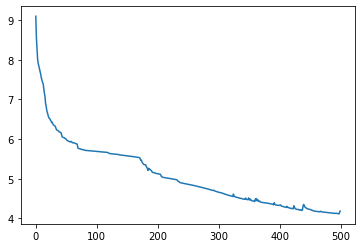

In [397]:
plt.plot(history.history['loss'])

In [398]:
eval_model(testing_x_gaf,testing_t,training_x_gaf,training_t)

66/66 - 0s - loss: 4.1558 - accuracy: 0.1824
Train accuracy: 0.18238095939159393

66/66 - 0s - loss: 7.4227 - accuracy: 0.0924
Test accuracy: 0.09238095581531525


In [207]:
#KMeans with DTW distance
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=10, metric="dtw", max_iter=10)
model.fit(training_x,training_t)

preds = model.predict(testing_x) == testing_t
sum = 0
for el in preds:
    if el == True:
        sum += 1
print("Accuracy:",sum/len(preds))

Accuracy: 0.06798245614035088
